In [8]:
import functools
from typing import Callable, Dict, List, Tuple, Union

import empyrical as ep
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from alphalens.tears import GridFigure
from scr.activation_funcs import Exp, ReLU, identity, sign, tanh
from scr.binary_operators import (
    Corr,
    get_x,
    get_y,
    operators_add,
    operators_diff,
    operators_max,
    operators_min,
    operators_multiple,
    x_is_greater_than_y,
)
from scr.company import Company
from scr.trader import Trader
from tqdm.notebook import tqdm


plt.rcParams["font.sans-serif"] = ["SimHei"]  # 设置字体
plt.rcParams["axes.unicode_minus"] = False  # 该语句解决图像中的“-”负号的乱码问题

d:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
d:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [3]:
codes: List = ["000300.SH", "000905.SH", "399006.SZ",'000906.SH','000852.SH','881001.WI']
price = pd.read_csv('Data\data.csv',index_col=[0],parse_dates=[0])

# 基础参数
activation_funcs: List[Callable] = [identity, ReLU, sign, tanh]
binary_operators: List[Callable] = [
    operators_max,
    operators_min,
    operators_add,
    operators_diff,
    get_x,
    get_y,
    operators_multiple,
    x_is_greater_than_y,
]

train_size:float = 0.4
seed = None

# 高斯分布

In [4]:
company_params = {
    "stock_names": codes,
    "M": 10,
    "max_lag": 9,
    "l": 1,
    "time_window": 100,
    "activation_funcs": activation_funcs,
    "binary_operators": binary_operators,
    "traders_num": 20,
    "Q": 0.5,
    'unimodal':'Gaussian',
    'evaluation_protocols':'ACC',
    "seed": seed,
}

model1 = Company(**company_params)

In [5]:
T_train: int = int(len(price) * train_size)
data: np.ndarray = price.values
df_y_train: np.ndarray = data[:T_train, :]

model1.fit(df_y_train)

TC模型训练:   0%|          | 0/1172 [00:00<?, ?it/s]

In [6]:
df_y_test: np.ndarray = data[T_train:, :]

signal_tmp: List = []
for row in tqdm(df_y_test):

    prediction_test = model1.aggregate()
    signal_tmp.append(prediction_test)

    model1.predict(row)

  0%|          | 0/1775 [00:00<?, ?it/s]

In [7]:
signal_arr: np.ndarray = np.squeeze(signal_tmp)

sign_signal: pd.DataFrame = pd.DataFrame(
    np.where(signal_arr > 0, 1, 0), columns=codes, index=price.iloc[T_train:].index
)

returns: pd.DataFrame = price.iloc[T_train:].shift(-1).mul(sign_signal, axis=1)
cum = ep.cum_returns(returns)
benchmark = ep.cum_returns(price.iloc[T_train:])

<Figure size 1008x1512 with 0 Axes>

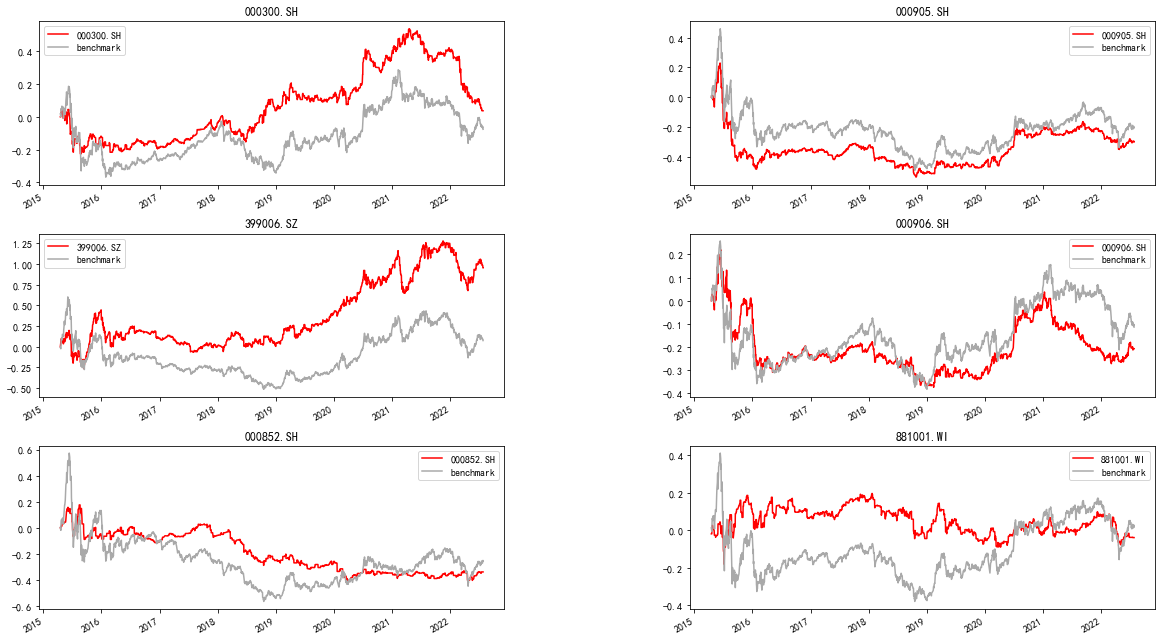

In [8]:
size: int = len(codes)
cols: int = 2
rows: int = size // cols + 1 if size % 2 else size // cols
gf = GridFigure(rows=rows, cols=cols)
gf.fig = plt.figure(figsize=(20, rows * 4))
for cum_sers, base_sers in zip(cum.items(), benchmark.items()):

    cum_name, cum_line = cum_sers
    base_name, base_line = base_sers

    line_ax = cum_line.plot(label=cum_name, ax=gf.next_cell(), color="r")
    base_line.plot(label="benchmark", ax=line_ax, color="darkgray")

    line_ax.legend()
    line_ax.set_title(cum_name)

plt.show()
gf.close()

# 高斯混合

In [9]:
company_params = {
    "stock_names": codes,
    "M": 10,
    "max_lag": 9,
    "l": 1,
    "time_window": 100,
    "activation_funcs": activation_funcs,
    "binary_operators": binary_operators,
    "traders_num": 20,
    "Q": 0.5,
    'unimodal':'GaussianMixture',
    'evaluation_protocols':'ACC',
    "seed": seed,
}

model2 = Company(**company_params)

In [10]:
T_train: int = int(len(price) * train_size)
data: np.ndarray = price.values
df_y_train: np.ndarray = data[:T_train, :]

model2.fit(df_y_train)

TC模型训练:   0%|          | 0/1172 [00:00<?, ?it/s]

In [11]:
df_y_test: np.ndarray = data[T_train:, :]

signal_tmp: List = []
for row in tqdm(df_y_test):

    prediction_test = model2.aggregate()
    signal_tmp.append(prediction_test)

    model2.predict(row)

  0%|          | 0/1775 [00:00<?, ?it/s]

In [12]:
signal_arr: np.ndarray = np.squeeze(signal_tmp)

sign_signal: pd.DataFrame = pd.DataFrame(
    np.where(signal_arr > 0, 1, 0), columns=codes, index=price.iloc[T_train:].index
)

returns: pd.DataFrame = price.iloc[T_train:].shift(-1).mul(sign_signal, axis=1)
cum = ep.cum_returns(returns)
benchmark = ep.cum_returns(price.iloc[T_train:])

<Figure size 1008x1512 with 0 Axes>

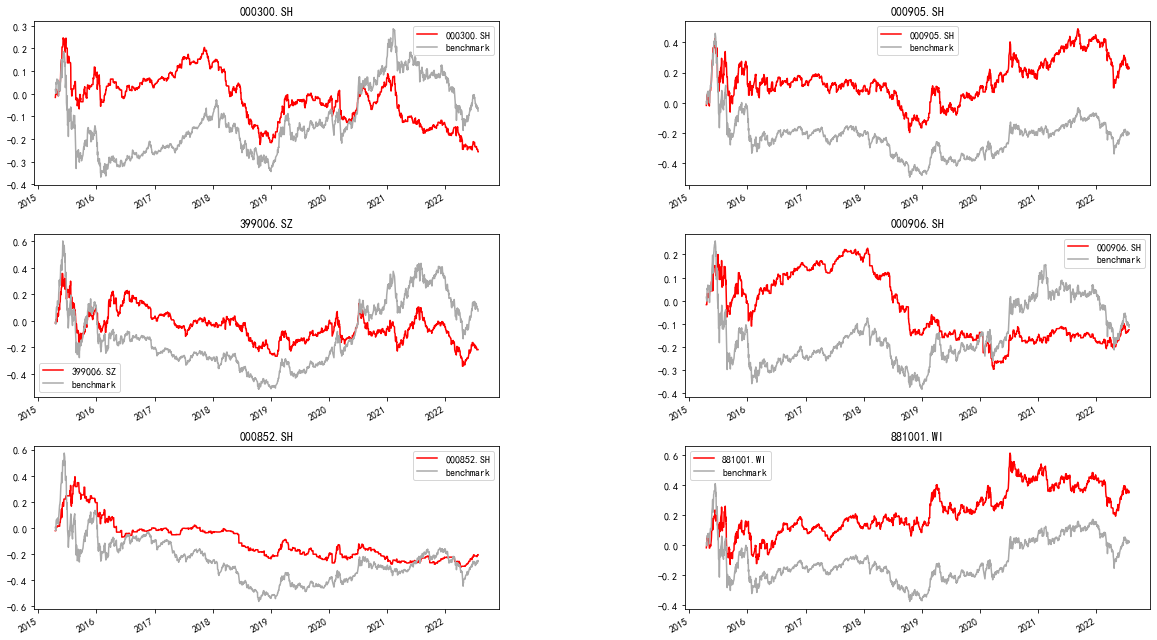

In [13]:
size: int = len(codes)
cols: int = 2
rows: int = size // cols + 1 if size % 2 else size // cols
gf = GridFigure(rows=rows, cols=cols)
gf.fig = plt.figure(figsize=(20, rows * 4))
for cum_sers, base_sers in zip(cum.items(), benchmark.items()):

    cum_name, cum_line = cum_sers
    base_name, base_line = base_sers

    line_ax = cum_line.plot(label=cum_name, ax=gf.next_cell(), color="r")
    base_line.plot(label="benchmark", ax=line_ax, color="darkgray")

    line_ax.legend()
    line_ax.set_title(cum_name)

plt.show()
gf.close()

# 贝叶斯

In [14]:
company_params = {
    "stock_names": codes,
    "M": 10,
    "max_lag": 9,
    "l": 1,
    "time_window": 100,
    "activation_funcs": activation_funcs,
    "binary_operators": binary_operators,
    "traders_num": 20,
    "Q": 0.5,
    'unimodal':'BayesianGaussianMixture',
    'evaluation_protocols':'ACC',
    "seed": seed,
}

model3 = Company(**company_params)

In [15]:
T_train: int = int(len(price) * train_size)
data: np.ndarray = price.values
df_y_train: np.ndarray = data[:T_train, :]

model3.fit(df_y_train)

TC模型训练:   0%|          | 0/1172 [00:00<?, ?it/s]

In [16]:
df_y_test: np.ndarray = data[T_train:, :]

signal_tmp: List = []
for row in tqdm(df_y_test):

    prediction_test = model3.aggregate()
    signal_tmp.append(prediction_test)

    model3.predict(row)

  0%|          | 0/1775 [00:00<?, ?it/s]

In [17]:
signal_arr: np.ndarray = np.squeeze(signal_tmp)

sign_signal: pd.DataFrame = pd.DataFrame(
    np.where(signal_arr > 0, 1, 0), columns=codes, index=price.iloc[T_train:].index
)

returns: pd.DataFrame = price.iloc[T_train:].shift(-1).mul(sign_signal, axis=1)
cum = ep.cum_returns(returns)
benchmark = ep.cum_returns(price.iloc[T_train:])

<Figure size 1008x1512 with 0 Axes>

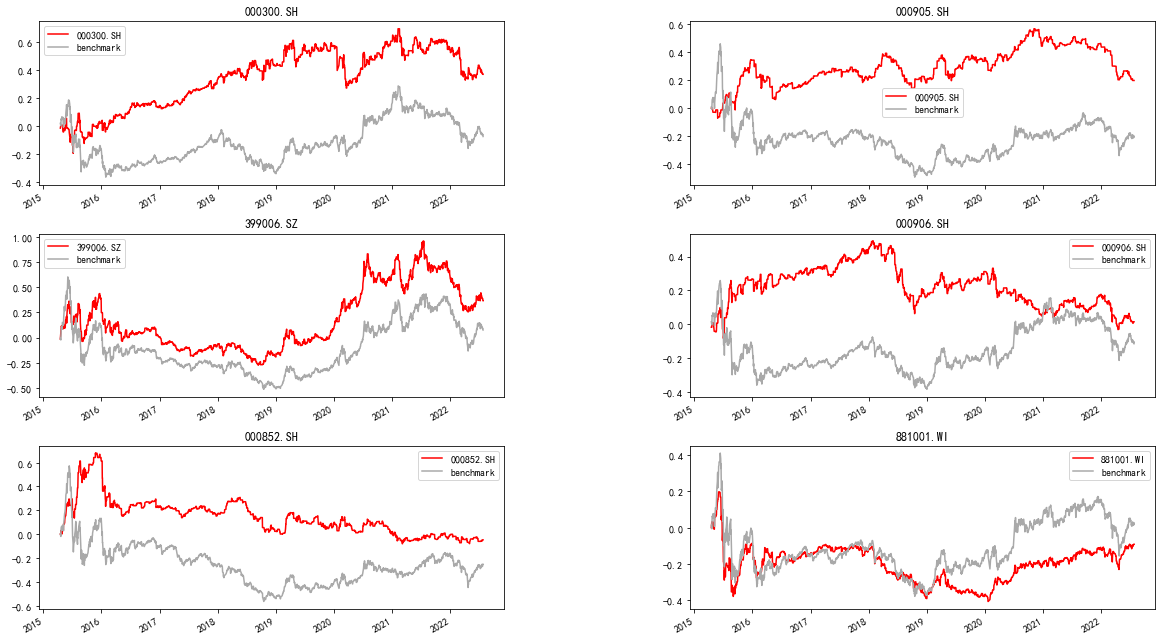

In [18]:
size: int = len(codes)
cols: int = 2
rows: int = size // cols + 1 if size % 2 else size // cols
gf = GridFigure(rows=rows, cols=cols)
gf.fig = plt.figure(figsize=(20, rows * 4))
for cum_sers, base_sers in zip(cum.items(), benchmark.items()):

    cum_name, cum_line = cum_sers
    base_name, base_line = base_sers

    line_ax = cum_line.plot(label=cum_name, ax=gf.next_cell(), color="r")
    base_line.plot(label="benchmark", ax=line_ax, color="darkgray")

    line_ax.legend()
    line_ax.set_title(cum_name)

plt.show()
gf.close()